In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
import yfinance as yf


In [42]:
starstart = '2010-01-01'
end = '2024-04-23'
stock = 'TSLA'

data = yf.download(stock, period="2y")  # Son 2 yılı aldım
print(data.head())

/tmp/ipython-input-3131019488.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock, period="2y")  # Son 2 yılı aldım
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            TSLA        TSLA        TSLA        TSLA       TSLA
Date                                                                 
2023-08-30  256.899994  260.510010  250.589996  254.199997  121988400
2023-08-31  258.079987  261.179993  255.050003  255.979996  108861700
2023-09-01  245.009995  259.079987  242.009995  257.260010  132541600
2023-09-05  256.489990  258.000000  244.860001  245.000000  129469600
2023-09-06  251.919998  255.389999  245.059998  255.139999  116959800


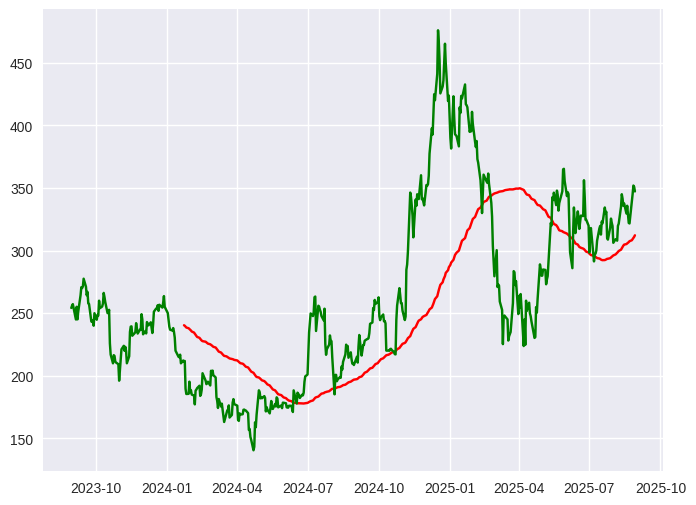

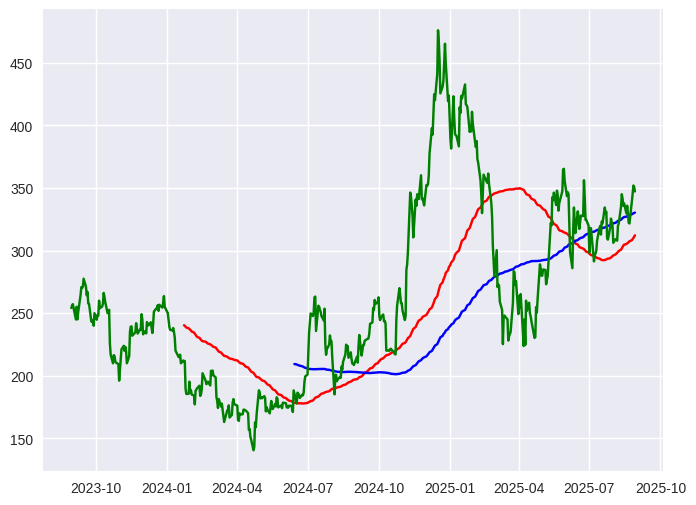

In [43]:

#100 gunluk hareketli ortalamanın grafiğini çizdirdim.
ma_100_days = data.Open.rolling(100).mean()
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(data.Open, 'g')
plt.show()

#son 200 günün hareketli ortalamasının grafiğini çizdiridm.
ma__200_days =data.Open.rolling(200).mean()
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(ma__200_days, 'b')
plt.plot(data.Open, 'g')
plt.show()


--- TSLA Analizi ---


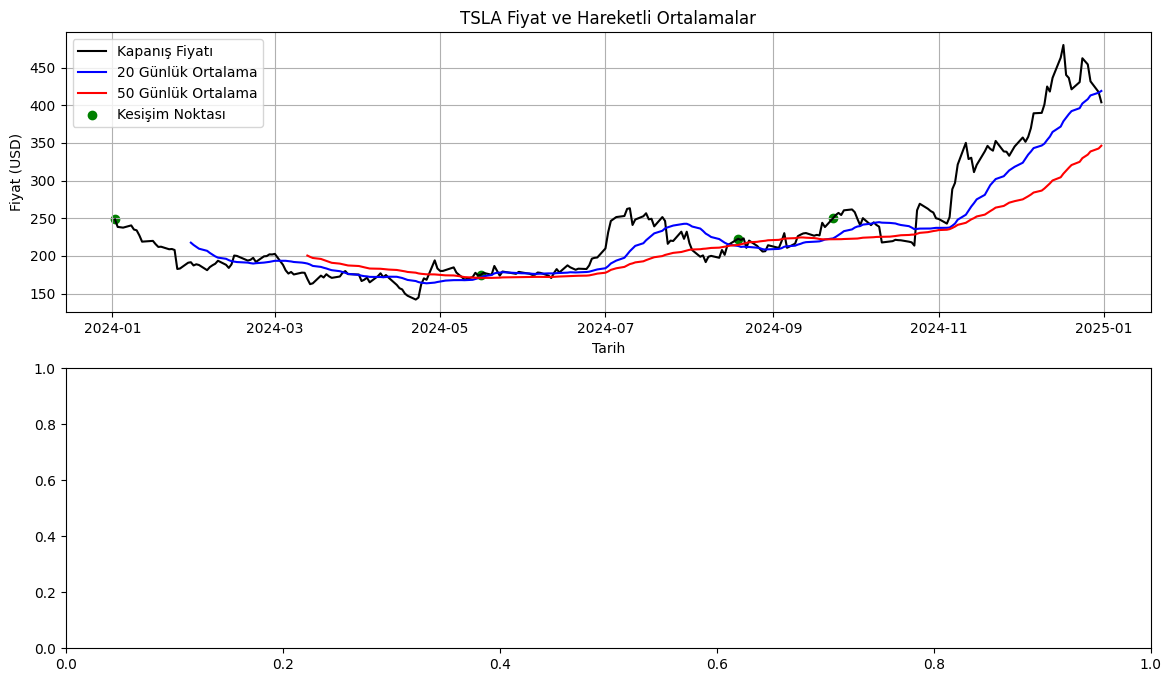

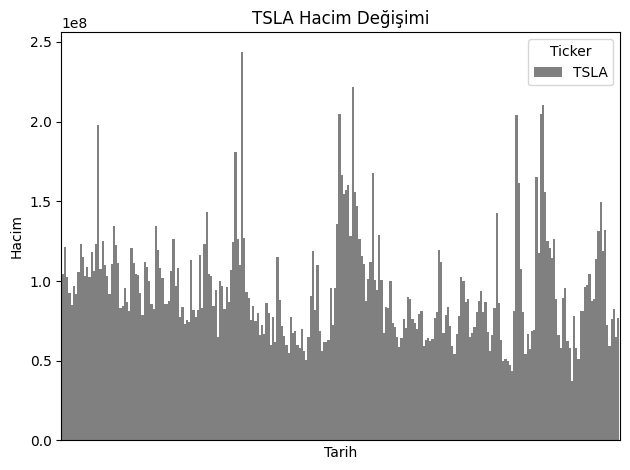

Kesişim Sayısı: 4
- TSLA daha istikrarlı, uzun vadeli yatırım için uygun olabilir.

--- MSFT Analizi ---


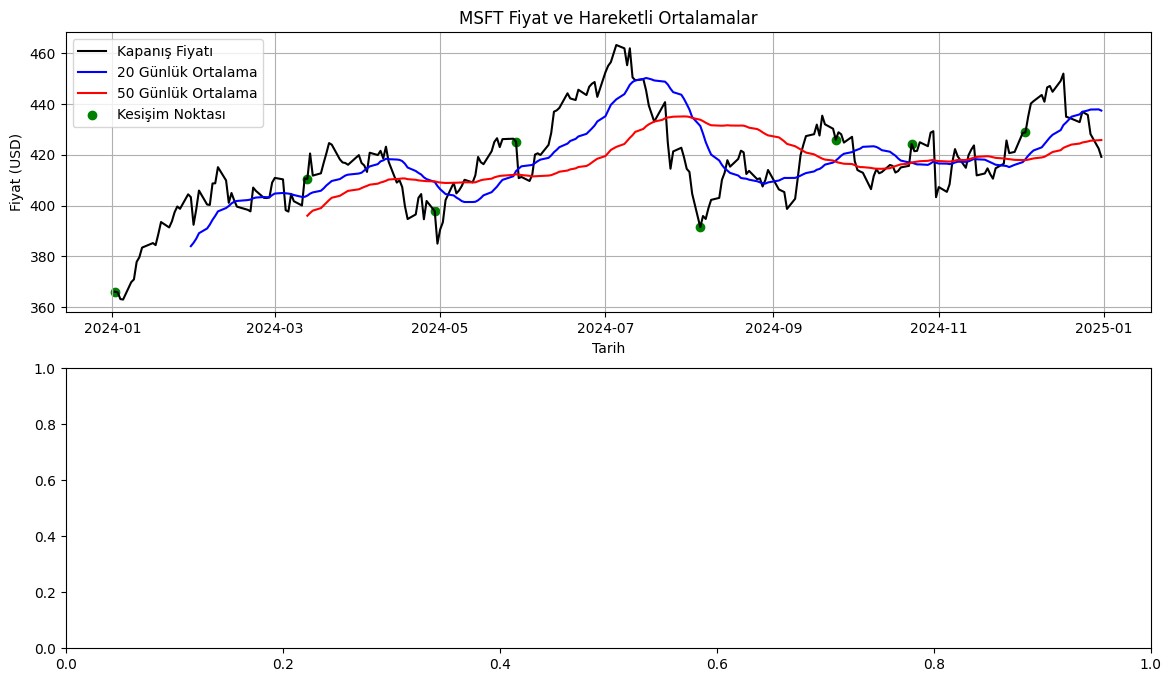

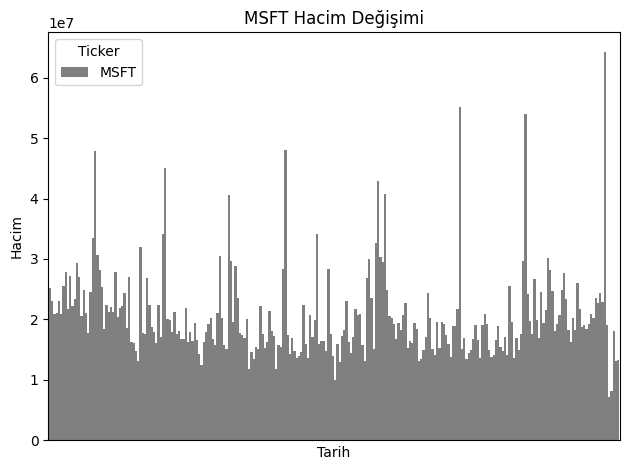

Kesişim Sayısı: 8
- MSFT daha istikrarlı, uzun vadeli yatırım için uygun olabilir.

--- KCHOL.IS Analizi ---


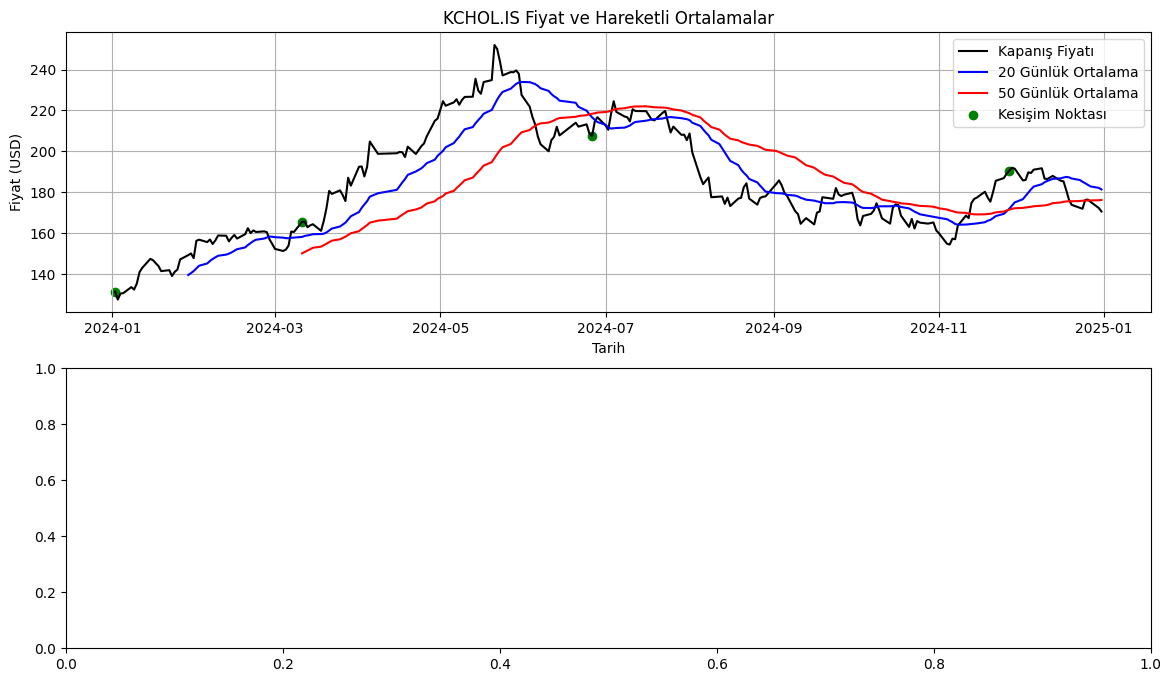

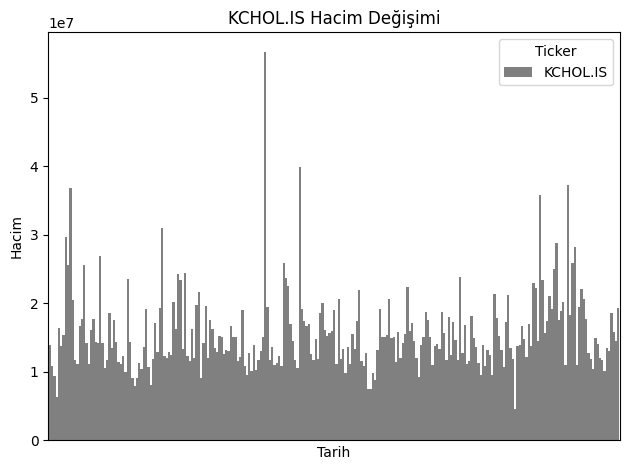

Kesişim Sayısı: 4
- KCHOL.IS daha istikrarlı, uzun vadeli yatırım için uygun olabilir.

--- THYAO.IS Analizi ---


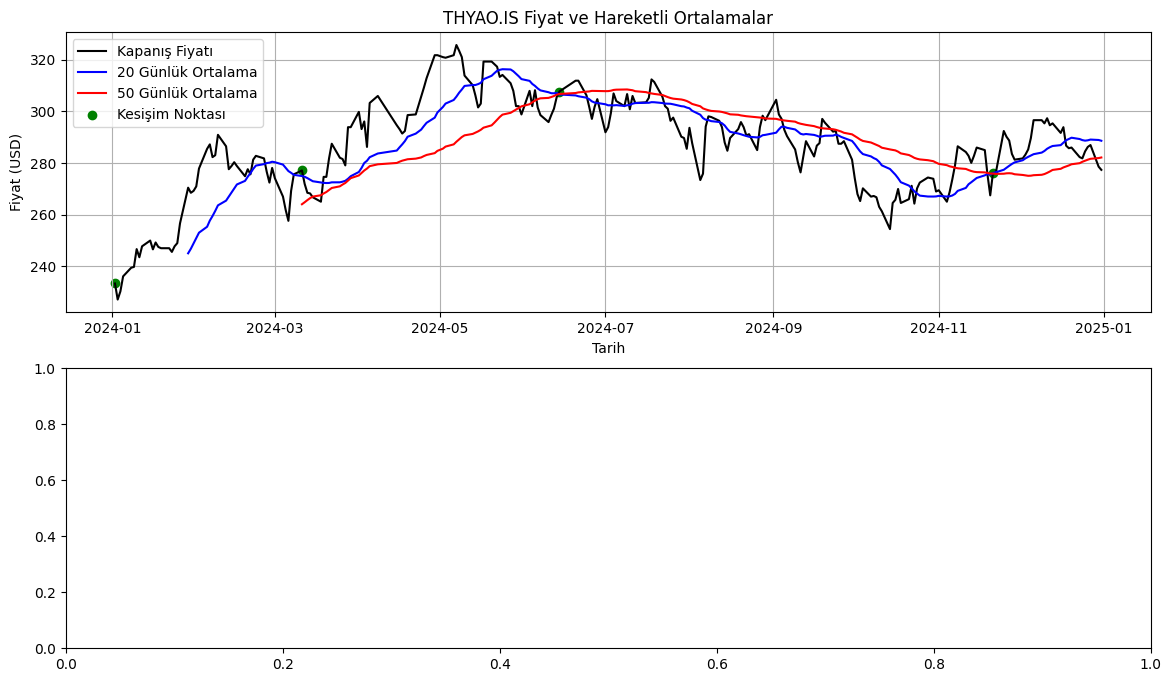

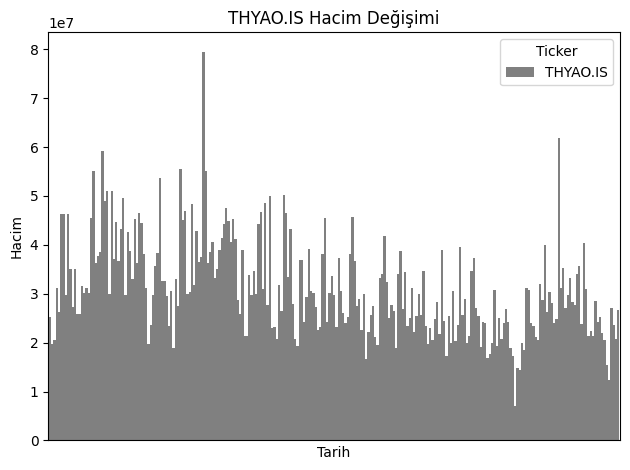

Kesişim Sayısı: 4
- THYAO.IS daha istikrarlı, uzun vadeli yatırım için uygun olabilir.


In [52]:
# Gerekli kütüphaneleri yükle
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("default")

# İncelenecek hisseler
tickers = ["TSLA", "MSFT", "KCHOL.IS", "THYAO.IS"]

# Tarih aralığı
start = "2024-01-01"
end = "2025-01-01"

# Verileri indirme
data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)

# Her hisse için analiz ve görselleştirme
for ticker, df in data.items():
    print(f"\n--- {ticker} Analizi ---")

    # Hareketli ortalamalar ekle
    df["SMA20"] = df["Close"].rolling(window=20).mean()
    df["SMA50"] = df["Close"].rolling(window=50).mean()

    # Trend kesişimlerini belirle
    df["Signal"] = df["SMA20"] > df["SMA50"]
    df["Cross"] = df["Signal"].ne(df["Signal"].shift())  # Kesişim olan noktalar

    # Grafik boyutu
    plt.figure(figsize=(14, 8))

    # === 1. Grafik: Fiyat ve hareketli ortalamalar ===
    plt.subplot(2, 1, 1)
    plt.plot(df.index, df["Close"], label="Kapanış Fiyatı", color="black")
    plt.plot(df.index, df["SMA20"], label="20 Günlük Ortalama", color="blue")
    plt.plot(df.index, df["SMA50"], label="50 Günlük Ortalama", color="red")
    plt.scatter(df[df["Cross"]].index, df[df["Cross"]]["Close"], color="green", marker="o", label="Kesişim Noktası")
    plt.title(f"{ticker} Fiyat ve Hareketli Ortalamalar")
    plt.xlabel("Tarih")
    plt.ylabel("Fiyat (USD)")
    plt.legend()
    plt.grid(True)

    # === 2. Grafik: Hacim değişimi (Pandas plot ile) ===
    plt.subplot(2, 1, 2)
    df["Volume"].fillna(0).astype(float).plot(kind="bar", width=1.0, color="gray")
    plt.title(f"{ticker} Hacim Değişimi")
    plt.xlabel("Tarih")
    plt.ylabel("Hacim")
    plt.xticks([])  # Çok fazla tarih etiketi olursa okunması zorlaşır

    plt.tight_layout()
    plt.show()

    # Basit yorumlama
    cross_count = df["Cross"].sum()
    print(f"Kesişim Sayısı: {cross_count}")
    if cross_count > 10:
        print(f"- {ticker} daha volatil, trend sık değişiyor.")
    else:
        print(f"- {ticker} daha istikrarlı, uzun vadeli yatırım için uygun olabilir.")


In [72]:
# TSLA verisini aldım
tsla_data = data["TSLA"]  # dict içinden DataFrame'i seç

# Sadece Open sütununu aldım
open_prices = tsla_data[["Open"]]


In [75]:
data = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)

open_prices = data[["Open"]]

# Ölçeklendirdim
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(open_prices)

# Eğitim ve test seti
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Sliding window fonksiyonu
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_step = 60

# Eğitim seti
X_train, y_train = create_dataset(train_data, time_step)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Test seti
if len(test_data) > time_step:
    X_test, y_test = create_dataset(test_data, time_step)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
else:
    # Test seti çok küçükse X_test boş olacak
    X_test, y_test = np.array([]), np.array([])
    print("Uyarı: Test seti sliding window için çok küçük!")

# Boyutları yazdırdım
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Uyarı: Test seti sliding window için çok küçük!
X_train shape: (139, 60, 1)
y_train shape: (139,)
X_test shape: (0,)
y_test shape: (0,)


In [76]:

#LSTM
model = Sequential()
model.add(LSTM(units = 50, activation='relu', return_sequences = True, input_shape = ((x.shape[1],1))))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation='relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation='relu',return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 100, activation='relu', ))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

#modeli derliyorum.
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
#10 epoch
model.fit(x,y, epochs = 10, batch_size = 25, verbose = 1)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - loss: 3.0452e-05
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1.4095e-05
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 4.2929e-06
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 2.3363e-06
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 4.1052e-06
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.4391e-06
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.0410e-07
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.1641e-06
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 8.6051e-07
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 6.6541e-07


In [81]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 100)            │        72,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 463,985 (1.77 MB)

 Trainable params: 154,661 (604.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 309,324 (1.18 MB)

In [82]:
pas_500_days = data_train.tail(100)

In [83]:
data_test = pd.concat([pas_500_days, data_test], ignore_index = True)

In [84]:
data_test_scale = scaler.fit_transform(data_test)
x = []
y = []

for i in range(100, data_test_scale.shape[0]):
    x.append(data_test_scale[i-100:i])
    y.append(data_test_scale[i,0])
x,y = np.array(x), np.array(y)

In [85]:
y_predict = model.predict(x)

5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step


In [86]:
print(y_predict)

[[0.00177878]
 [0.00177794]
 [0.00177688]
 [0.00177559]
 [0.00177418]
 [0.00177276]
 [0.00177144]
 [0.00177029]
 [0.00176947]
 [0.00176896]
 [0.00176874]
 [0.00176881]
 [0.00176917]
 [0.00176968]
 [0.00177023]
 [0.00177078]
 [0.00177126]
 [0.00177164]
 [0.00177192]
 [0.00177209]
 [0.00177217]
 [0.00177217]
 [0.00177206]
 [0.00177185]
 [0.00177154]
 [0.00177115]
 [0.00177073]
 [0.00177043]
 [0.00177039]
 [0.00177062]
 [0.00177113]
 [0.00177197]
 [0.00177307]
 [0.00177434]
 [0.00177569]
 [0.00177705]
 [0.00177832]
 [0.00177943]
 [0.00178032]
 [0.001781  ]
 [0.00178139]
 [0.00178145]
 [0.00178122]
 [0.0017808 ]
 [0.00178027]
 [0.00177971]
 [0.00177917]
 [0.00177861]
 [0.0017779 ]
 [0.00177697]
 [0.00177588]
 [0.00177465]
 [0.00177331]
 [0.00177194]
 [0.00177058]
 [0.0017693 ]
 [0.00176814]
 [0.00176716]
 [0.00176638]
 [0.00176583]
 [0.00176554]
 [0.00176552]
 [0.00176568]
 [0.00176598]
 [0.00176632]
 [0.00176665]
 [0.00176689]
 [0.00176703]
 [0.00176709]
 [0.00176708]
 [0.00176707]
 [0.00

In [87]:
scale = scaler.scale_
print(scale)

[0.00328106]


In [88]:
y_predict = y_predict*scale

In [89]:
y = y*scale

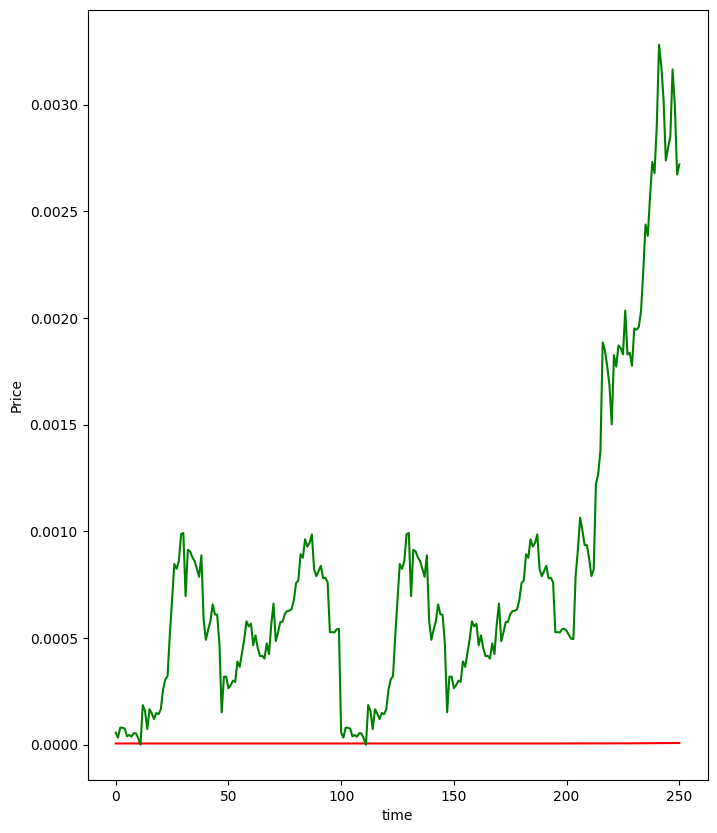

In [90]:
plt.figure(figsize=(8,10))
plt.plot(y_predict, 'r', label = 'predict Price')
plt.plot(y, 'g', label = 'original Price')
plt.xlabel('time')
plt.ylabel('Price')
plt.legend
plt.show()

In [91]:
model.save('tsla.keras')

In [92]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

# Karelerin ortalamasını alarak MSE (Mean Squared Error) hesapladım
mse = mean_squared_error(y, y_predict)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 1.0888809617374823e-06
